In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [3]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > 81:",long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes,batch_first=True)
    return data,torch.tensor(labels)


In [4]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("../compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [5]:
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [6]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm.csv', header=False, index=False)
val.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm.csv', header=False, index=False)

In [17]:
train_data,train_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm.csv",81)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm.csv",81)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm.csv",81)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 81: 0
torch.Size([142397, 30]) torch.Size([142397])
length > 81: 0
torch.Size([35600, 30]) torch.Size([35600])
length > 81: 0
torch.Size([44499, 30]) torch.Size([44499])


# 2. train

In [12]:
device = torch.device("cuda",0)

In [18]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
#         print(output.shape, hn.shape)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive

In [29]:
for num_model in range(5):
    net=newModel().to(device)
    lr = 0.0001
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
#         to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'./Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 166.34050, loss1: 1.74163, loss2_3: 164.59887
	train_acc: 0.7271, test_acc: 0.7252528089887641, time: 152.02
best_acc: 0.7252528089887641
epoch: 2, loss: 114.07835, loss1: 0.91585, loss2_3: 113.16250
	train_acc: 0.8104, test_acc: 0.8102247191011236, time: 151.62
best_acc: 0.8102247191011236
epoch: 3, loss: 101.77880, loss1: 0.84985, loss2_3: 100.92894
	train_acc: 0.8338, test_acc: 0.8328370786516854, time: 151.89
best_acc: 0.8328370786516854
epoch: 4, loss: 97.03369, loss1: 0.80558, loss2_3: 96.22811
	train_acc: 0.8270, test_acc: 0.827556179775281, time: 152.10
epoch: 5, loss: 94.41471, loss1: 0.78242, loss2_3: 93.63229
	train_acc: 0.8412, test_acc: 0.8415730337078652, time: 151.30
best_acc: 0.8415730337078652
epoch: 6, loss: 92.93334, loss1: 0.77017, loss2_3: 92.16317
	train_acc: 0.8477, test_acc: 0.8491573033707865, time: 152.78
best_acc: 0.8491573033707865
epoch: 7, loss: 92.04901, loss1: 0.75468, loss2_3: 91.29433
	train_acc: 0.8491, test_acc: 0.848623595505618, tim

epoch: 58, loss: 78.14204, loss1: 0.62658, loss2_3: 77.51546
	train_acc: 0.8721, test_acc: 0.8681741573033708, time: 151.73
epoch: 59, loss: 77.92629, loss1: 0.62325, loss2_3: 77.30304
	train_acc: 0.8739, test_acc: 0.8701123595505618, time: 150.57
epoch: 60, loss: 78.12247, loss1: 0.62504, loss2_3: 77.49744
	train_acc: 0.8731, test_acc: 0.8692977528089888, time: 152.08
epoch: 61, loss: 77.96358, loss1: 0.62236, loss2_3: 77.34122
	train_acc: 0.8729, test_acc: 0.8671067415730337, time: 151.38
epoch: 62, loss: 77.95131, loss1: 0.62321, loss2_3: 77.32810
	train_acc: 0.8741, test_acc: 0.8704213483146067, time: 151.66
epoch: 63, loss: 77.88663, loss1: 0.62064, loss2_3: 77.26599
	train_acc: 0.8726, test_acc: 0.8665730337078652, time: 151.52
epoch: 64, loss: 77.60878, loss1: 0.61986, loss2_3: 76.98892
	train_acc: 0.8745, test_acc: 0.8689325842696629, time: 151.80
epoch: 65, loss: 77.62119, loss1: 0.62056, loss2_3: 77.00062
	train_acc: 0.8752, test_acc: 0.8695224719101123, time: 151.98
epoch: 6

epoch: 119, loss: 74.57052, loss1: 0.59726, loss2_3: 73.97326
	train_acc: 0.8813, test_acc: 0.871629213483146, time: 151.65
epoch: 120, loss: 74.56740, loss1: 0.59821, loss2_3: 73.96919
	train_acc: 0.8824, test_acc: 0.8723314606741573, time: 151.06
epoch: 121, loss: 74.42412, loss1: 0.59917, loss2_3: 73.82494
	train_acc: 0.8813, test_acc: 0.8706179775280899, time: 152.65
epoch: 122, loss: 74.58578, loss1: 0.59902, loss2_3: 73.98676
	train_acc: 0.8826, test_acc: 0.8726685393258427, time: 151.99
epoch: 123, loss: 74.58110, loss1: 0.60155, loss2_3: 73.97955
	train_acc: 0.8816, test_acc: 0.8717696629213483, time: 150.90
epoch: 124, loss: 74.38289, loss1: 0.59557, loss2_3: 73.78732
	train_acc: 0.8817, test_acc: 0.870252808988764, time: 151.83
epoch: 125, loss: 74.56777, loss1: 0.59862, loss2_3: 73.96915
	train_acc: 0.8802, test_acc: 0.8686797752808989, time: 150.98
epoch: 126, loss: 74.42205, loss1: 0.59902, loss2_3: 73.82303
	train_acc: 0.8809, test_acc: 0.871938202247191, time: 151.92
epo

epoch: 180, loss: 71.37382, loss1: 0.58100, loss2_3: 70.79281
	train_acc: 0.8895, test_acc: 0.8698595505617978, time: 126.70
epoch: 181, loss: 71.27949, loss1: 0.58144, loss2_3: 70.69805
	train_acc: 0.8879, test_acc: 0.8707584269662921, time: 126.49
epoch: 182, loss: 71.18733, loss1: 0.57732, loss2_3: 70.61001
	train_acc: 0.8851, test_acc: 0.8678932584269663, time: 126.99
epoch: 183, loss: 71.13735, loss1: 0.57687, loss2_3: 70.56048
	train_acc: 0.8906, test_acc: 0.871685393258427, time: 128.50
epoch: 184, loss: 71.14530, loss1: 0.57966, loss2_3: 70.56564
	train_acc: 0.8893, test_acc: 0.868314606741573, time: 125.97
epoch: 185, loss: 71.03333, loss1: 0.57964, loss2_3: 70.45369
	train_acc: 0.8893, test_acc: 0.8696348314606741, time: 127.72
epoch: 186, loss: 70.79782, loss1: 0.57526, loss2_3: 70.22256
	train_acc: 0.8912, test_acc: 0.8707303370786517, time: 126.94
epoch: 187, loss: 70.89135, loss1: 0.57950, loss2_3: 70.31185
	train_acc: 0.8909, test_acc: 0.8726123595505618, time: 127.14
ep

epoch: 242, loss: 67.12840, loss1: 0.55559, loss2_3: 66.57280
	train_acc: 0.9007, test_acc: 0.8692977528089888, time: 128.23
epoch: 243, loss: 67.04458, loss1: 0.55521, loss2_3: 66.48937
	train_acc: 0.8937, test_acc: 0.8656179775280899, time: 126.31
epoch: 244, loss: 66.89626, loss1: 0.55660, loss2_3: 66.33966
	train_acc: 0.9017, test_acc: 0.8690730337078652, time: 126.95
epoch: 245, loss: 66.79155, loss1: 0.55291, loss2_3: 66.23863
	train_acc: 0.9020, test_acc: 0.8702247191011236, time: 126.79
epoch: 246, loss: 66.89477, loss1: 0.55389, loss2_3: 66.34088
	train_acc: 0.9015, test_acc: 0.8709269662921348, time: 126.93
epoch: 247, loss: 66.70399, loss1: 0.55546, loss2_3: 66.14853
	train_acc: 0.8997, test_acc: 0.8681741573033708, time: 127.23
epoch: 248, loss: 66.41705, loss1: 0.55367, loss2_3: 65.86338
	train_acc: 0.9021, test_acc: 0.868623595505618, time: 125.92
epoch: 249, loss: 66.53418, loss1: 0.55201, loss2_3: 65.98216
	train_acc: 0.8996, test_acc: 0.8689325842696629, time: 127.33
e

epoch: 48, loss: 79.90334, loss1: 0.64168, loss2_3: 79.26166
	train_acc: 0.8692, test_acc: 0.8678651685393258, time: 155.31
epoch: 49, loss: 79.78164, loss1: 0.63656, loss2_3: 79.14508
	train_acc: 0.8693, test_acc: 0.8685393258426967, time: 151.82
best_acc: 0.8685393258426967
epoch: 50, loss: 79.84904, loss1: 0.63738, loss2_3: 79.21167
	train_acc: 0.8683, test_acc: 0.8661516853932584, time: 151.43
epoch: 51, loss: 79.67137, loss1: 0.63737, loss2_3: 79.03400
	train_acc: 0.8708, test_acc: 0.8702808988764045, time: 291.47
best_acc: 0.8702808988764045
epoch: 52, loss: 79.44661, loss1: 0.63646, loss2_3: 78.81015
	train_acc: 0.8710, test_acc: 0.8685674157303371, time: 385.88
epoch: 53, loss: 79.47188, loss1: 0.63459, loss2_3: 78.83729
	train_acc: 0.8658, test_acc: 0.8614044943820225, time: 243.41
epoch: 54, loss: 79.32572, loss1: 0.63441, loss2_3: 78.69131
	train_acc: 0.8715, test_acc: 0.8693258426966292, time: 268.33
epoch: 55, loss: 79.08127, loss1: 0.63298, loss2_3: 78.44830
	train_acc: 0

epoch: 109, loss: 75.93355, loss1: 0.60555, loss2_3: 75.32800
	train_acc: 0.8783, test_acc: 0.8731741573033708, time: 103.30
epoch: 110, loss: 75.68937, loss1: 0.60364, loss2_3: 75.08574
	train_acc: 0.8792, test_acc: 0.8727528089887641, time: 103.86
epoch: 111, loss: 75.69480, loss1: 0.60501, loss2_3: 75.08980
	train_acc: 0.8788, test_acc: 0.8731460674157303, time: 104.00
epoch: 112, loss: 75.58095, loss1: 0.60257, loss2_3: 74.97837
	train_acc: 0.8775, test_acc: 0.8712359550561798, time: 104.02
epoch: 113, loss: 75.61919, loss1: 0.60623, loss2_3: 75.01296
	train_acc: 0.8781, test_acc: 0.8729494382022472, time: 103.71
epoch: 114, loss: 75.44820, loss1: 0.60576, loss2_3: 74.84243
	train_acc: 0.8779, test_acc: 0.8720786516853932, time: 103.76
epoch: 115, loss: 75.59705, loss1: 0.61042, loss2_3: 74.98663
	train_acc: 0.8774, test_acc: 0.8706460674157304, time: 104.15
epoch: 116, loss: 75.45195, loss1: 0.60444, loss2_3: 74.84750
	train_acc: 0.8738, test_acc: 0.8680056179775281, time: 103.72


epoch: 170, loss: 73.65372, loss1: 0.59040, loss2_3: 73.06332
	train_acc: 0.8823, test_acc: 0.8704494382022472, time: 74.26
epoch: 171, loss: 73.74445, loss1: 0.59128, loss2_3: 73.15317
	train_acc: 0.8833, test_acc: 0.8749157303370787, time: 74.88
best_acc: 0.8749157303370787
epoch: 172, loss: 73.76639, loss1: 0.59035, loss2_3: 73.17604
	train_acc: 0.8811, test_acc: 0.8694662921348315, time: 74.86
epoch: 173, loss: 73.51931, loss1: 0.59095, loss2_3: 72.92836
	train_acc: 0.8832, test_acc: 0.8727808988764045, time: 74.06
epoch: 174, loss: 73.62758, loss1: 0.59375, loss2_3: 73.03383
	train_acc: 0.8842, test_acc: 0.8731460674157303, time: 73.32
epoch: 175, loss: 73.43793, loss1: 0.59120, loss2_3: 72.84673
	train_acc: 0.8845, test_acc: 0.8734550561797753, time: 74.76
epoch: 176, loss: 73.41499, loss1: 0.59348, loss2_3: 72.82151
	train_acc: 0.8843, test_acc: 0.8741292134831461, time: 74.88
epoch: 177, loss: 73.34189, loss1: 0.58928, loss2_3: 72.75260
	train_acc: 0.8836, test_acc: 0.873258426

epoch: 232, loss: 71.66729, loss1: 0.57887, loss2_3: 71.08842
	train_acc: 0.8851, test_acc: 0.87, time: 74.04
epoch: 233, loss: 71.71643, loss1: 0.57939, loss2_3: 71.13704
	train_acc: 0.8857, test_acc: 0.8693258426966292, time: 73.79
epoch: 234, loss: 71.84243, loss1: 0.58122, loss2_3: 71.26121
	train_acc: 0.8876, test_acc: 0.8707584269662921, time: 75.20
epoch: 235, loss: 71.68099, loss1: 0.58089, loss2_3: 71.10010
	train_acc: 0.8882, test_acc: 0.8733426966292135, time: 74.96
epoch: 236, loss: 71.65054, loss1: 0.58244, loss2_3: 71.06809
	train_acc: 0.8899, test_acc: 0.8719662921348315, time: 75.07
epoch: 237, loss: 71.56415, loss1: 0.58103, loss2_3: 70.98313
	train_acc: 0.8890, test_acc: 0.8726966292134831, time: 73.67
epoch: 238, loss: 71.58699, loss1: 0.58113, loss2_3: 71.00586
	train_acc: 0.8886, test_acc: 0.8709550561797753, time: 74.34
epoch: 239, loss: 71.46080, loss1: 0.58226, loss2_3: 70.87854
	train_acc: 0.8899, test_acc: 0.8711516853932584, time: 75.14
epoch: 240, loss: 71.4

epoch: 41, loss: 80.24643, loss1: 0.64008, loss2_3: 79.60635
	train_acc: 0.8715, test_acc: 0.8703932584269662, time: 75.05
best_acc: 0.8703932584269662
epoch: 42, loss: 79.83617, loss1: 0.63856, loss2_3: 79.19761
	train_acc: 0.8711, test_acc: 0.8696348314606741, time: 74.83
epoch: 43, loss: 79.61544, loss1: 0.64005, loss2_3: 78.97539
	train_acc: 0.8715, test_acc: 0.8705898876404494, time: 73.18
best_acc: 0.8705898876404494
epoch: 44, loss: 79.63897, loss1: 0.63771, loss2_3: 79.00126
	train_acc: 0.8719, test_acc: 0.8699719101123595, time: 74.72
epoch: 45, loss: 79.57081, loss1: 0.63570, loss2_3: 78.93511
	train_acc: 0.8721, test_acc: 0.8693539325842696, time: 74.82
epoch: 46, loss: 79.51684, loss1: 0.63490, loss2_3: 78.88194
	train_acc: 0.8711, test_acc: 0.8700842696629213, time: 75.01
epoch: 47, loss: 79.23487, loss1: 0.63593, loss2_3: 78.59894
	train_acc: 0.8733, test_acc: 0.8715168539325843, time: 74.17
best_acc: 0.8715168539325843
epoch: 48, loss: 79.31307, loss1: 0.63398, loss2_3: 

epoch: 102, loss: 75.13001, loss1: 0.60675, loss2_3: 74.52326
	train_acc: 0.8801, test_acc: 0.8711516853932584, time: 73.12
epoch: 103, loss: 75.26444, loss1: 0.60077, loss2_3: 74.66367
	train_acc: 0.8809, test_acc: 0.8736797752808989, time: 74.49
epoch: 104, loss: 74.93713, loss1: 0.59834, loss2_3: 74.33879
	train_acc: 0.8779, test_acc: 0.8688483146067416, time: 74.74
epoch: 105, loss: 74.98938, loss1: 0.60270, loss2_3: 74.38669
	train_acc: 0.8808, test_acc: 0.8719943820224719, time: 74.77
epoch: 106, loss: 74.98649, loss1: 0.60012, loss2_3: 74.38637
	train_acc: 0.8815, test_acc: 0.8729775280898876, time: 74.39
epoch: 107, loss: 74.72262, loss1: 0.59866, loss2_3: 74.12396
	train_acc: 0.8807, test_acc: 0.8708426966292134, time: 73.22
epoch: 108, loss: 74.96792, loss1: 0.60113, loss2_3: 74.36679
	train_acc: 0.8812, test_acc: 0.8723033707865169, time: 74.71
epoch: 109, loss: 74.64582, loss1: 0.59963, loss2_3: 74.04619
	train_acc: 0.8802, test_acc: 0.8709269662921348, time: 74.92
epoch: 1

epoch: 164, loss: 71.69501, loss1: 0.58752, loss2_3: 71.10749
	train_acc: 0.8884, test_acc: 0.8735112359550562, time: 74.80
epoch: 165, loss: 71.62356, loss1: 0.58114, loss2_3: 71.04242
	train_acc: 0.8891, test_acc: 0.8726685393258427, time: 74.88
epoch: 166, loss: 71.61938, loss1: 0.57866, loss2_3: 71.04072
	train_acc: 0.8884, test_acc: 0.8734550561797753, time: 74.57
epoch: 167, loss: 71.66165, loss1: 0.58023, loss2_3: 71.08142
	train_acc: 0.8876, test_acc: 0.8715168539325843, time: 73.04
epoch: 168, loss: 71.60818, loss1: 0.57714, loss2_3: 71.03104
	train_acc: 0.8908, test_acc: 0.8741011235955056, time: 74.57
best_acc: 0.8741011235955056
epoch: 169, loss: 71.57462, loss1: 0.57908, loss2_3: 70.99554
	train_acc: 0.8891, test_acc: 0.8716011235955056, time: 74.64
epoch: 170, loss: 71.45853, loss1: 0.57784, loss2_3: 70.88069
	train_acc: 0.8870, test_acc: 0.8696629213483146, time: 74.90
epoch: 171, loss: 71.46158, loss1: 0.57803, loss2_3: 70.88354
	train_acc: 0.8894, test_acc: 0.873342696

epoch: 226, loss: 67.07374, loss1: 0.55495, loss2_3: 66.51879
	train_acc: 0.9008, test_acc: 0.8711516853932584, time: 74.80
epoch: 227, loss: 66.97578, loss1: 0.55754, loss2_3: 66.41824
	train_acc: 0.9005, test_acc: 0.8698876404494382, time: 73.28
epoch: 228, loss: 66.92131, loss1: 0.55878, loss2_3: 66.36253
	train_acc: 0.8980, test_acc: 0.8683426966292135, time: 74.14
epoch: 229, loss: 66.76412, loss1: 0.55253, loss2_3: 66.21159
	train_acc: 0.9002, test_acc: 0.8713202247191011, time: 74.82
epoch: 230, loss: 66.92851, loss1: 0.55497, loss2_3: 66.37354
	train_acc: 0.8979, test_acc: 0.8701404494382022, time: 74.82
epoch: 231, loss: 66.96542, loss1: 0.55663, loss2_3: 66.40878
	train_acc: 0.8977, test_acc: 0.8677247191011236, time: 74.58
epoch: 232, loss: 66.71306, loss1: 0.55370, loss2_3: 66.15935
	train_acc: 0.9014, test_acc: 0.8712359550561798, time: 72.79
epoch: 233, loss: 66.65567, loss1: 0.55563, loss2_3: 66.10003
	train_acc: 0.9001, test_acc: 0.8716011235955056, time: 74.58
epoch: 2

epoch: 35, loss: 81.92733, loss1: 0.65582, loss2_3: 81.27151
	train_acc: 0.8680, test_acc: 0.8665168539325843, time: 74.94
best_acc: 0.8665168539325843
epoch: 36, loss: 82.13264, loss1: 0.65417, loss2_3: 81.47848
	train_acc: 0.8657, test_acc: 0.864691011235955, time: 74.82
epoch: 37, loss: 81.55462, loss1: 0.65316, loss2_3: 80.90146
	train_acc: 0.8658, test_acc: 0.8629775280898876, time: 74.25
epoch: 38, loss: 81.48491, loss1: 0.65112, loss2_3: 80.83379
	train_acc: 0.8680, test_acc: 0.8658146067415731, time: 73.44
epoch: 39, loss: 81.46216, loss1: 0.64872, loss2_3: 80.81343
	train_acc: 0.8615, test_acc: 0.8582865168539325, time: 74.92
epoch: 40, loss: 81.27865, loss1: 0.65095, loss2_3: 80.62770
	train_acc: 0.8673, test_acc: 0.866376404494382, time: 74.93
epoch: 41, loss: 81.35147, loss1: 0.64821, loss2_3: 80.70326
	train_acc: 0.8705, test_acc: 0.868061797752809, time: 74.88
best_acc: 0.868061797752809
epoch: 42, loss: 80.90702, loss1: 0.64467, loss2_3: 80.26235
	train_acc: 0.8680, test

epoch: 95, loss: 75.96024, loss1: 0.60390, loss2_3: 75.35635
	train_acc: 0.8788, test_acc: 0.8731460674157303, time: 75.01
epoch: 96, loss: 75.78150, loss1: 0.60791, loss2_3: 75.17358
	train_acc: 0.8795, test_acc: 0.8729494382022472, time: 74.94
epoch: 97, loss: 75.94135, loss1: 0.60708, loss2_3: 75.33427
	train_acc: 0.8796, test_acc: 0.8732022471910112, time: 74.64
epoch: 98, loss: 75.67301, loss1: 0.60566, loss2_3: 75.06735
	train_acc: 0.8794, test_acc: 0.871376404494382, time: 73.08
epoch: 99, loss: 75.60429, loss1: 0.60513, loss2_3: 74.99916
	train_acc: 0.8788, test_acc: 0.8724438202247191, time: 74.84
epoch: 100, loss: 75.49202, loss1: 0.60654, loss2_3: 74.88547
	train_acc: 0.8782, test_acc: 0.8712359550561798, time: 75.02
epoch: 101, loss: 75.60382, loss1: 0.60471, loss2_3: 74.99911
	train_acc: 0.8793, test_acc: 0.8731179775280898, time: 74.99
epoch: 102, loss: 75.58287, loss1: 0.60924, loss2_3: 74.97363
	train_acc: 0.8793, test_acc: 0.8728370786516854, time: 73.99
epoch: 103, lo

epoch: 157, loss: 72.91923, loss1: 0.58940, loss2_3: 72.32983
	train_acc: 0.8860, test_acc: 0.8730056179775281, time: 74.62
epoch: 158, loss: 72.85222, loss1: 0.58683, loss2_3: 72.26539
	train_acc: 0.8860, test_acc: 0.8731741573033708, time: 75.08
epoch: 159, loss: 72.81719, loss1: 0.58849, loss2_3: 72.22870
	train_acc: 0.8867, test_acc: 0.8732865168539325, time: 75.17
epoch: 160, loss: 72.74823, loss1: 0.58626, loss2_3: 72.16197
	train_acc: 0.8843, test_acc: 0.8723876404494382, time: 74.41
epoch: 161, loss: 72.59940, loss1: 0.58684, loss2_3: 72.01256
	train_acc: 0.8855, test_acc: 0.8714887640449438, time: 73.28
epoch: 162, loss: 72.60635, loss1: 0.58504, loss2_3: 72.02132
	train_acc: 0.8846, test_acc: 0.8698876404494382, time: 75.09
epoch: 163, loss: 72.53385, loss1: 0.58764, loss2_3: 71.94621
	train_acc: 0.8866, test_acc: 0.873061797752809, time: 75.05
epoch: 164, loss: 72.43418, loss1: 0.58682, loss2_3: 71.84735
	train_acc: 0.8869, test_acc: 0.8733426966292135, time: 75.12
epoch: 16

epoch: 219, loss: 68.74286, loss1: 0.56574, loss2_3: 68.17712
	train_acc: 0.8960, test_acc: 0.8702808988764045, time: 74.89
epoch: 220, loss: 68.92646, loss1: 0.56812, loss2_3: 68.35834
	train_acc: 0.8974, test_acc: 0.8703370786516854, time: 73.46
epoch: 221, loss: 68.81938, loss1: 0.56765, loss2_3: 68.25173
	train_acc: 0.8957, test_acc: 0.8697752808988765, time: 74.01
epoch: 222, loss: 68.61715, loss1: 0.56581, loss2_3: 68.05134
	train_acc: 0.8979, test_acc: 0.8712921348314607, time: 74.91
epoch: 223, loss: 68.66962, loss1: 0.56193, loss2_3: 68.10769
	train_acc: 0.8959, test_acc: 0.8697191011235955, time: 74.78
epoch: 224, loss: 68.43855, loss1: 0.56151, loss2_3: 67.87705
	train_acc: 0.8964, test_acc: 0.8705898876404494, time: 74.78
epoch: 225, loss: 68.36566, loss1: 0.55860, loss2_3: 67.80706
	train_acc: 0.8898, test_acc: 0.8662640449438203, time: 73.15
epoch: 226, loss: 68.52762, loss1: 0.56277, loss2_3: 67.96485
	train_acc: 0.8964, test_acc: 0.8712078651685393, time: 74.67
epoch: 2

epoch: 28, loss: 83.29667, loss1: 0.66735, loss2_3: 82.62932
	train_acc: 0.8652, test_acc: 0.8638764044943821, time: 75.02
epoch: 29, loss: 83.09768, loss1: 0.66681, loss2_3: 82.43088
	train_acc: 0.8649, test_acc: 0.8639044943820224, time: 74.98
epoch: 30, loss: 82.81535, loss1: 0.66549, loss2_3: 82.14986
	train_acc: 0.8655, test_acc: 0.8640168539325843, time: 74.02
epoch: 31, loss: 82.65809, loss1: 0.66361, loss2_3: 81.99449
	train_acc: 0.8667, test_acc: 0.8658146067415731, time: 73.62
best_acc: 0.8658146067415731
epoch: 32, loss: 83.05391, loss1: 0.66291, loss2_3: 82.39100
	train_acc: 0.8643, test_acc: 0.8626404494382023, time: 75.06
epoch: 33, loss: 82.46041, loss1: 0.65905, loss2_3: 81.80136
	train_acc: 0.8666, test_acc: 0.8642696629213483, time: 75.00
epoch: 34, loss: 82.22346, loss1: 0.66034, loss2_3: 81.56313
	train_acc: 0.8673, test_acc: 0.8649719101123595, time: 74.93
epoch: 35, loss: 81.98361, loss1: 0.65627, loss2_3: 81.32734
	train_acc: 0.8661, test_acc: 0.8633426966292135,

epoch: 89, loss: 76.42891, loss1: 0.61075, loss2_3: 75.81817
	train_acc: 0.8764, test_acc: 0.8709550561797753, time: 73.97
epoch: 90, loss: 76.35208, loss1: 0.61101, loss2_3: 75.74107
	train_acc: 0.8765, test_acc: 0.8697752808988765, time: 73.79
epoch: 91, loss: 76.15389, loss1: 0.60974, loss2_3: 75.54415
	train_acc: 0.8777, test_acc: 0.8693539325842696, time: 75.11
epoch: 92, loss: 75.99060, loss1: 0.60596, loss2_3: 75.38464
	train_acc: 0.8788, test_acc: 0.8721629213483146, time: 75.04
best_acc: 0.8721629213483146
epoch: 93, loss: 76.07101, loss1: 0.61280, loss2_3: 75.45820
	train_acc: 0.8789, test_acc: 0.871123595505618, time: 75.33
epoch: 94, loss: 76.00815, loss1: 0.60707, loss2_3: 75.40107
	train_acc: 0.8779, test_acc: 0.8713202247191011, time: 73.56
epoch: 95, loss: 76.20362, loss1: 0.60848, loss2_3: 75.59514
	train_acc: 0.8762, test_acc: 0.867808988764045, time: 74.57
epoch: 96, loss: 75.94701, loss1: 0.60598, loss2_3: 75.34103
	train_acc: 0.8800, test_acc: 0.8722752808988764, t

epoch: 150, loss: 73.05570, loss1: 0.58857, loss2_3: 72.46713
	train_acc: 0.8857, test_acc: 0.8725842696629214, time: 73.99
epoch: 151, loss: 72.92210, loss1: 0.59029, loss2_3: 72.33181
	train_acc: 0.8857, test_acc: 0.8725, time: 74.98
epoch: 152, loss: 72.95904, loss1: 0.58955, loss2_3: 72.36949
	train_acc: 0.8856, test_acc: 0.8714606741573033, time: 74.90
epoch: 153, loss: 72.90264, loss1: 0.59217, loss2_3: 72.31047
	train_acc: 0.8845, test_acc: 0.8690168539325843, time: 74.71
epoch: 154, loss: 73.01715, loss1: 0.58762, loss2_3: 72.42952
	train_acc: 0.8868, test_acc: 0.8728932584269663, time: 72.98
epoch: 155, loss: 73.05304, loss1: 0.58642, loss2_3: 72.46662
	train_acc: 0.8844, test_acc: 0.8691011235955056, time: 74.46
epoch: 156, loss: 73.07864, loss1: 0.58914, loss2_3: 72.48950
	train_acc: 0.8846, test_acc: 0.871629213483146, time: 74.82
epoch: 157, loss: 72.91700, loss1: 0.58959, loss2_3: 72.32742
	train_acc: 0.8866, test_acc: 0.8727528089887641, time: 74.82
epoch: 158, loss: 72.

epoch: 212, loss: 69.87587, loss1: 0.56799, loss2_3: 69.30788
	train_acc: 0.8912, test_acc: 0.868061797752809, time: 74.89
epoch: 213, loss: 69.97193, loss1: 0.57168, loss2_3: 69.40026
	train_acc: 0.8923, test_acc: 0.8692977528089888, time: 75.13
epoch: 214, loss: 69.83677, loss1: 0.57040, loss2_3: 69.26638
	train_acc: 0.8882, test_acc: 0.8646629213483146, time: 73.60
epoch: 215, loss: 69.73704, loss1: 0.56973, loss2_3: 69.16732
	train_acc: 0.8949, test_acc: 0.871123595505618, time: 73.93
epoch: 216, loss: 69.55449, loss1: 0.56734, loss2_3: 68.98715
	train_acc: 0.8949, test_acc: 0.8707022471910112, time: 75.01
epoch: 217, loss: 69.48110, loss1: 0.57165, loss2_3: 68.90944
	train_acc: 0.8952, test_acc: 0.8714606741573033, time: 74.87
epoch: 218, loss: 69.84137, loss1: 0.56866, loss2_3: 69.27271
	train_acc: 0.8950, test_acc: 0.8698314606741573, time: 74.87
epoch: 219, loss: 69.76466, loss1: 0.56995, loss2_3: 69.19471
	train_acc: 0.8943, test_acc: 0.8703370786516854, time: 73.12
epoch: 220

# 3. test

In [20]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [21]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [22]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

Test Accuracy: 0.8678172543203218
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     22330
           1       0.85      0.90      0.87     22169

    accuracy                           0.87     44499
   macro avg       0.87      0.87      0.87     44499
weighted avg       0.87      0.87      0.87     44499

rf auc : 0.9391573548608613


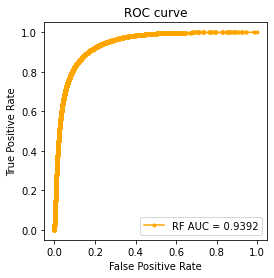

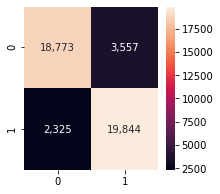

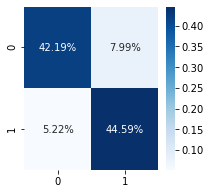

In [30]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()